# classical neural network belief propagation
Implementing the classical NNBP`[1]`, I implementing this by Pytorch`[2]`.  
At first, I also give weight by a weight matrix *W_var* to the message transmit from check points to variables. As the train goes on there will give a nan outcome caused by the negative weight in *W_var*, so I clamp it under 1e-10. After training, **it turns out the loss acting like overfitting, the loss has a 1e-8 magnitude** (the plain BP give a loss/bit error rate around 0.14).  
Also, the author and coworkers have made progress`[3]` `[4]` `[5]`. They modify their initial idea and what is worth for this work is they **remove the weight of the poterior probabilistic distribution** because the aim to add the weight is to ease the unreliable message passing from the loop. **The PPD which are solid messages and they should not be added weights**, so I remove it here.  
Moreover, the most attention-attracting stuff in the neural-decoding community is how to prevent or release the effect of overfitting. Though NNBP has the power of easing overffing, but I have seen no mathematic prove over this. **The exploitation of the power of deep learning and generalization** obviously deserve more attention.  


In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import math
import torch 
import os
from torch.autograd import Variable
import time
import torch.utils.data as Data
from torch import autograd

### **First Part: set the hyperparameters**  
Note that Nc is the iterations the BP algorithm will do which we set it 5.

In [ ]:
torch.autograd.set_detect_anomaly(True)
BATCH_SIZE = 120
lr = 1e-3
Nc = 5

### **Second Part: define the class to get the simulated received data**  
We need to simulate the sent data which is x and get the received data y and the posterior probabilistic distribution(PPD) which we will use in the BP algorithm. The data take **a form of voltage(sine wave)** transmitting in the channel which we assume it is **an addictive Gaussian white noise (AWGN)channel** and it need modulate before transmission.  
Here, to make it easy for computing the PPD of the received data, we would like to modulate the original 0 and 1 in the data to have a same amplitude and inverse phase, moreover, we wan to get a close result to the original paper, so we choose **the modulating function to be 0.6 - 1.2 * x** after trailing. Using the properties of the AWGN chaneel we can get the PPD.  
Class Gen_Data use to get the simulated received data and the PPD and CustomDataset defining the dataset class.

In [ ]:
class Gen_Data(torch.nn.Module):
    def __init__(self, SNR, num, batch_num):
        super(Gen_Data, self).__init__()
        SNR = torch.DoubleTensor(SNR).unsqueeze(0)
        self.Sigma = ((0.36 / (10 ** (SNR / 10)) ** 0.5).repeat(1, num)).repeat(1, batch_num)
        
    def modulate(self, inverse, x):
        if not inverse:
            return 0.6 - 1.2 * x
        else:
            return (0.6 - x) / 1.2
    
    def AWGN(self, x):
        x_prime = self.modulate(0, x)
        noise = torch.normal(0.0, self.Sigma.t().mm(torch.ones((1, x.size()[1]), dtype = torch.float64))) #minibatch x n
        y_prime = x_prime + noise
        post = self.get_post(y_prime)
        y = self.modulate(1, y_prime)
        return y, post
    
    def get_post(self, x):
        post = 2 * x.mul(1 / ((self.Sigma ** 2).t().repeat(1, x.size()[1])))
        return post
    
class CustomDataset(Data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        return self.dataset[index]
    
    def __len__(self):
        return self.dataset.size()[0]

### **Thrid Part: defining one iteration of the belief propagation**  
Next step, we define one iteration in the belief propagation which here is one neural network layer here.  
We **make the message passing more natural by introducing variable `H` and `thorch.where`**. Using torch.where we can make the message passing only on the exsiting edge of the Tanner graph which here is the `H` matrix. Moreover we introduce variable check to do element-wise multiplication to parameter `W_check` to keep the diagonal elements keep to be zero while training also it need to leave the off-diagnal elements unchanged.  
Note that the iterations crray out by `[1]` are element-wise. To make advantage of Pytorch, we shall modify the formula to matrix operation. The modified equation(4) become  
$M_{vc} =L\cdot H^T+M_{cv}^T\cdot (W_{check}\bigotimes H^T)$,  
use the trick,  
$ln(x)=ln|x|+i\cdot \pi, x<0$,  
Equation(5) become  
$M_{cv}=2\cdot arctanh[cos(\pi \cdot Coeff)\bigotimes exp(ln|tanh(M_{cv} / 2)|)]$,  
where `Coeff` matrix is the coefficient matrix to log the negative elements of the product of function $tanh(x / 2)$.  
Equation(6) become  
$M=M_{cv}^T\cdot W_{vec}+L$.  
As is illustrated in the NNBP paper`[1]`, in order to train the parmeters in every layer in the NNBP, we need to return the result of every layer, so we define a list *results* to store the results.

In [ ]:
class BPBlock(torch.nn.Module):
    def __init__(self, H):
        super(BPBlock, self).__init__()
        self.H = Variable(H, requires_grad = False)
        self.rows, self.cols = H.size()
        self.W_check = torch.nn.Parameter((torch.ones((self.rows, self.rows), dtype = torch.float64) - \
                                           torch.eye(self.rows, dtype = torch.float64)))
        self.W_vec = torch.nn.Parameter(Variable(torch.ones((self.rows, 1), dtype = torch.float64)))
        
    def forward(self, x):
        L, M_check, results = x
        H = Variable(torch.ones((M_check.size()), dtype = torch.float64)).mul(self.H)
        check = Variable(torch.ones((self.rows, self.rows), dtype = torch.float64) - \
                         torch.eye(self.rows, dtype = torch.float64))
        var = Variable(torch.ones((self.cols, self.cols), dtype = torch.float64) - \
                       torch.eye(self.cols, dtype = torch.float64))
        result = M_check
        result = torch.where(H.transpose(1, 2) == 0, result.transpose(1, 2), \
                             torch.matmul(result.transpose(1, 2), self.W_check.mul(check)))
        result += torch.matmul(L, self.H.t())
        '''
        It is always need in BP to clamp the absolute of the product under 10 before tanh(x), so as NNBP.
        '''
        result = torch.clamp(result, -10, 10)
        result = torch.where(H.transpose(1, 2) == 0, result, torch.tanh(result / 2))
        Coeff = torch.where(result < 0, torch.ones(result.size(), dtype = torch.float64), \
                            torch.zeros(result.size(), dtype = torch.float64))
        result = torch.where(H.transpose(1, 2) == 0, result, abs(result))
        '''
        Here we add a bias to the unconnected edge in the Tanner graph to avoid an unexpected exception in the program which will lead to
        nan in the gradients, after log(x), we need to subtract it.
        '''
        result = torch.where(H.transpose(1, 2) == 0, result + 3, result)
        result = torch.where(H.transpose(1, 2) == 0, result, torch.log(result))
        result = torch.where(H.transpose(1, 2) == 0, result - 3, result)
        result = torch.where(H == 0, result.transpose(1, 2), torch.matmul(result.transpose(1, 2), var))
        result = torch.where(H == 0, result, torch.exp(result))
        Coeff = torch.where(H == 0, Coeff.transpose(1, 2), torch.matmul(Coeff.transpose(1, 2), var))
        result = torch.where(H == 0, result, torch.cos(math.pi * Coeff).mul(result))
        result = torch.where(H == 0, result, torch.log((1 + result) / (1 - result)))
        output = result
        result = torch.matmul(output.transpose(1, 2), self.W_vec)
        result += torch.matmul(L, Variable(torch.ones((self.cols, 1), dtype = torch.float64)))
        result = torch.sigmoid(-1 * result)
        '''
        The result here will evaluate using cross entropy loss. To stabilize the product we need to clamp the result.
        '''
        result = torch.clamp(result, 1e-40, 1 - 1e-16)
        results.append(result)
        return L, output, results

### **Fourth Part: neural network belief propagation**  
Here we use function *_make_layer()* to define a sequential of iteration in the BP algorithm. Also we set the initial message contain in the node all to be zero correspond to the zero matrix *M_check_init*. We set the PPD of the received data to be a diagonal matrix *L*.

In [ ]:
class NNBP(torch.nn.Module):
    def __init__(self, H, Nc):
        super(NNBP, self).__init__()
        self.H = H
        self.rows, self.cols = H.size()
        self.Nc = Nc
        self.layer = self._make_layer()
        
    def _make_layer(self):
        layers = []
        for i in range(self.Nc):
            layers.append(BPBlock(self.H))
        return torch.nn.Sequential(*layers)
        
    def forward(self, x):
        L = Variable(torch.zeros((x.size()[0], self.cols, self.cols), dtype = torch.float64))
        for i in range(x.size()[0]):
            L[i] = torch.diag(x[i])
        results = []
        M_check_init = Variable(torch.zeros((x.size()[0], self.rows, self.cols), dtype = torch.float64))
        x = (L, M_check_init, results)
        x = self.layer(x)
        return x[2]

### **Fifth Part: loss function and train**
Here using cross entropy loss function as showed in the paper. During train we shall use *results* defined above to log the result of every layer for trainning. If not train, we shall use variable *loss_sum*  to get the total loss.

In [ ]:
class LossFunc(torch.nn.Module):
    def __init__(self):
        super(LossFunc, self).__init__()

    def forward(self, result, x):
        x = x.t()
        loss_b = torch.log(result)
        loss_a = torch.log(1 - result)
        loss = (1 - x).mul(loss_a) + x.mul(loss_b)
        loss = torch.sum(loss) / (-1 * torch.numel(loss))
        return loss
    
def training(H, dataset, x, lr, train_num, train, load):
    #step1:claim the model
    loss_sum = 0
    decoder = NNBP(H, Nc)
    if load:
        decoder.load_state_dict(torch.load('.\model\decoder_parameters.pkl'))
#        for name, param in decoder.named_parameters():
#            if param.requires_grad:
#                print(name,torch.where(param > 0.0, torch.zeros(param.size(), dtype = torch.float64), param).to_sparse()._values())
#                print(name,param)
#        return 0

    #step2:load data
    torch_dataset = CustomDataset(dataset)
    loader = Data.DataLoader(
        dataset = torch_dataset,      # torch TensorDataset format
        batch_size = BATCH_SIZE,      # mini batch size
        shuffle = False,               # random shuffle for training
        num_workers = 3,              # subprocesses for loading data
    )
    
    #step3:loss func & optimizer
    criterion = LossFunc()
    optimizer = torch.optim.RMSprop(decoder.parameters(), lr = lr)

    #step4:train
    for epoch in range(train_num):
        print('epoch',epoch)
        for step, post in enumerate(loader):
            loss = Variable(torch.zeros((1), dtype = torch.float64))
            post = Variable(post).float()
            optimizer.zero_grad()
            results = decoder(post)
            if train:
                for result in results:
                    loss += criterion(result, x)
                loss /= len(results)
                loss.backward()
#                for name, param in decoder.named_parameters():
#                    if param.requires_grad:
#                        print(name,param.grad)                                
                optimizer.step()
                for p in decoder.parameters():
                    p.data.clamp_(1e-10)
            else:
                loss_sum += criterion(results[len(results) - 1], x)
    if train:
        torch.save(decoder.state_dict(), '.\model\decoder_parameters.pkl')
        return loss
    else: return loss_sum

### **Sixth Part: training the neural network**
Here I show three different model, the middle one is what we use to compare the performance between BP and NNBP using BCH(63,45) code.

In [ ]:
if __name__ == '__main__':
    '''
    classical LDPC(no training)
    '''
#    num = 20
#    batch_num = 50
#    SNR = [0.1,0.2,0.3,0.4,0.5,0.6]
#    H_LDPC = torch.DoubleTensor([[1,1,1,0,0,0,1,0,0,0,0],
#                           [0,0,0,1,1,1,0,1,0,0,0],
#                           [1,0,0,1,0,0,0,0,1,0,0],
#                           [0,1,0,0,1,0,0,0,0,1,0],
#                           [0,0,1,0,0,1,0,0,0,0,1]])
#    data = Gen_Data(SNR, num, batch_num)
#    x = torch.DoubleTensor([[0,1,0,0,0,0,1,0,0,1,0]])
#    y, post = data.AWGN(x)
#    loss = training(H_LDPC, post, x, lr, 1, 0, 0)
#    print(loss / batch_num)
    '''
    classical HDPC,记录loss
    '''
    num = 20
    batch_num = 30
    train_num = 100
    train = 1
    load = 0
    SNR = [0.1,0.2,0.3,0.4,0.5,0.6] #signal noise rate
    H_BCH = torch.from_numpy(np.loadtxt('BCH(63,45).txt'))
    data = Gen_Data(SNR, num, batch_num)
    x = torch.zeros((1, 63), dtype = torch.float64)
    y, post = data.AWGN(x)
    loss = training(H_BCH, post, x, lr, train_num, train, load)
    print(loss / batch_num)
    '''
    检测结果
    '''
#    num = 20
#    batch_num = 20
#    SNR = [0.1,0.2,0.3,0.4,0.5,0.6]
#    H_BCH = torch.from_numpy(np.loadtxt('BCH(63,45).txt'))
#    data = Gen_Data(SNR, num, batch_num)
#    x = torch.zeros((1, 63), dtype = torch.float64)
#    y, post = data.AWGN(x)
#    loss = training(H_BCH, post, x, lr, 1, 0, 1)
#    print(loss / batch_num)

### **Seventh Part: results and evaluation**  
Here shows four models' results. The models are plain BP, standard NNBP which is nat having the parameters assigned to PPD, NNBP as showned in `[1]` and NNBP with parameters W_var which is assign to the second step of message passing.  
We can see the extrame enhancement of performance as more parameters added to the model. The reason why my results outperform these of `[1]` may lie in the modulation been used.

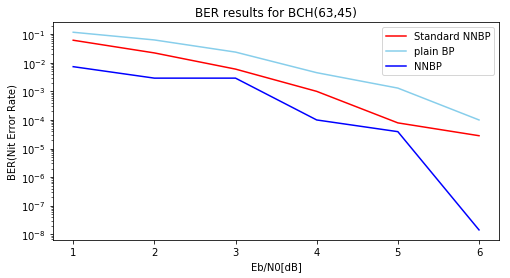

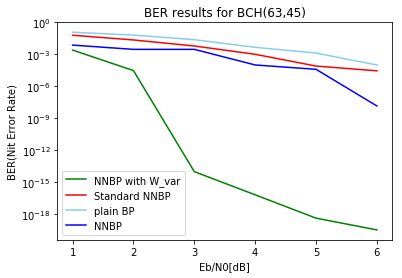

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = [1, 2, 3, 4, 5, 6]
W_var = [0.0025, 2.9790e-05, 9.9648e-15, 6.6909e-17, 4.3518e-19, 3.4364e-20]
Standard = [0.0614 ,0.0221 ,0.0060 ,0.0010 ,7.9001e-05 ,2.8113e-05]
BP = [0.1168, 0.0628, 0.0236, 0.0045, 0.0013, 0.0001]
B = [0.0073, 0.0029, 0.0029, 0.0001, 3.8960e-05, 1.4266e-08]
plt.figure(figsize=(8,4))
plt.plot(x, Standard, color = 'red', label = 'Standard NNBP')
plt.plot(x, BP,  color = 'skyblue', label = 'plain BP')
plt.plot(x, B, color = 'blue', label = 'NNBP')
plt.xlabel("Eb/N0[dB]")
plt.ylabel("BER(Nit Error Rate)")
plt.title("BER results for BCH(63,45)")
plt.yscale('log') 
plt.legend()
plt.show()

plt.plot(x, W_var, color = 'green', label = 'NNBP with W_var')
plt.plot(x, Standard, color = 'red', label = 'Standard NNBP')
plt.plot(x, BP,  color = 'skyblue', label = 'plain BP')
plt.plot(x, B, color = 'blue', label = 'NNBP')
plt.xlabel("Eb/N0[dB]")
plt.ylabel("BER(Nit Error Rate)")
plt.title("BER results for BCH(63,45)")
plt.yscale('log') 
plt.legend()
plt.show()

### **Reference**

`[1]`:  E. Nachmani, Y. Be’ery, and D. Burshtein, “Learning to decode linear codes using deep learning,” in 54’th Annual Allerton Conf. On Communication, Control and Computing, September 2016.  
`[2]`: https://pytorch.org/  
`[3]`:  E. Nachmani, E. Marciano, D. Burshtein, and Y. Be’ery, “RNN decoding of linear block codes,” arXiv preprint arXiv:1702.07560, 2017.  
`[4]`:  E. Nachmani, Y. Bachar, E. Marciano, D. Burshtein, and Y. Beery, “Near maximum likelihood decoding with deep learning,” in The International Zurich Seminar on Information and Communication, 2018, pp. 40–44  
`[5]`:  E. Nachmani, E. Marciano, L. Lugosch, W. J. Gross, D. Burshtein, and Y. Be’ery, “Deep learning methods for improved decoding of linear codes,” IEEE Journal of Selected Topics in Signal Processing, 2018.